<a href="https://colab.research.google.com/github/hpink97/ML_notebooks/blob/main/CelebA_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI generate human faces using Generative Adversarial Networks (GANs)

GANs work by training 2 models simoultaneously **(generator & discriminator)** - which are trying to fool each other... 

Generator acts as the artist. It takes in completley random inputs and attempts to general believable looking images. The discrimiator is a standard image classification model which attempts to tell real images from fake. 

In training the generator will become better at producing believable images, and the discrimator will become better at detecting the fake images, until an equilibrium is reached.

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


import matplotlib.pyplot as plt

#file manipulation
import os
import zipfile
import random

## Import CelebA dataset - images of celebrities faces

In [3]:
!mkdir data_faces && wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip 

--2023-02-14 08:33:21--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.112.168
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.112.168|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘celeba.zip’

celeba.zip          100%[===================>]   1.34G  20.4MB/s    in 69s     

2023-02-14 08:34:30 (20.0 MB/s) - ‘celeba.zip’ saved [1443490838/1443490838]



In [4]:
##unzip
with zipfile.ZipFile("celeba.zip","r") as zip_ref:
  zip_ref.extractall("data_faces/")

root = 'data_faces/img_align_celeba'
img_list = os.listdir(root)
print(len(img_list))

202599


In [6]:
random.shuffle(img_list)
remove = img_list[75000:]
for f in remove:
    os.remove(os.path.join(root, f))

img_list = os.listdir(root)
print(len(img_list))

75000


Found 75000 files belonging to 1 classes.


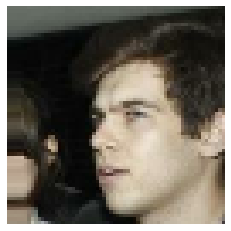

In [7]:
##import datset using keras
faces = keras.utils.image_dataset_from_directory(
    root,
    ##don't care about original labels - for our GAN they'll all be labelled REAL
    label_mode = None, 
    ##resize image to 64*64 - limited GPU!!
    image_size = (64,64),
    batch_size = 32, 
    smart_resize = True 
)

##show sample face
for batch in faces:
  face = batch.numpy().astype('int32')[12]
  plt.axis('off')
  plt.imshow(face)
  break


In [22]:
face.shape

(64, 64, 3)

In [23]:
##scale values to 0-1
faces=faces.map(lambda x:x/255.) #scale between 0-1


## GAN Discriminator - classify real vs fake images

Striding seems to work better in GANs than MaxPooling. Also using LeakyReLU seems to also work better...

In [24]:
discriminator = keras.Sequential(
    [
    keras.Input(shape=(64,64,3)), #input an image
    layers.Conv2D(filters =64, kernel_size = 4, strides=2, padding = 'same'), 
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(filters =128, kernel_size = 4, strides=2, padding = 'same'), 
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(filters =128, kernel_size = 4, strides=2, padding = 'same'), 
    layers.LeakyReLU(alpha=0.2),
    layers.Flatten(),
    layers.Dropout(0.25),
    layers.Dense(1, activation='sigmoid'),
    ],
    name = 'discriminator',
)

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 8192)            

## GAN Generator 

This model will accept a random nornally distributed vector (**latent space**) as input, and generate a 64x64x3 image as output. Image will be noise to start with, but after training of model weights image should resemble a human face. 

**`Conv2DTranspose `** layers will be used to perform **deconvolution** (opposite on convolution), to generate the images. 

Kernel size of `Conv2dTransponse` layers **MUST** be divisible by stride size to avoid checkboard artifacts (linked to unequal coverage of pixel space by generator) 

`strides = 2` causes Output height x width to half in each `Conv2D layer` and dounle in each `Conv2DTransponse` layer. Important as generator model needs to reverse the dimensions of the discriminator (in order to end up with a 64x64x3 image)

In [25]:
latent_space_dim = 128 

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_space_dim,)),
    ##should be same dimension of discriminators flattened layer (8192)
        layers.Dense(8*8*128), 
     ##reverse flattening - get back to output shape from last Conv2D layer
        layers.Reshape((8,8,128)),
     ##start deconvolution 
        layers.Conv2DTranspose(128, kernel_size =4, strides=2, padding ='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size =4, strides=2, padding ='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size =4, strides=2, padding ='same'),
        layers.LeakyReLU(alpha=0.2), 
        layers.Conv2D(filters = 3, ##reverts back to 3 channel image
                      kernel_size = 5, 
                      padding = 'same',
                      activation = 'sigmoid'),
     ], name = 'generator'
)

generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                                       
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 32, 32, 256)       0 

## Adversiral Network - combine discriminator and generator in a model

In [47]:
##devlop GAN class inheriting from keras model
class GAN(keras.Model):
  def __init__(self, discriminator, generator, latent_space_dim):
    super().__init__()
    #add the two models
    self.discriminator = discriminator
    self.generator = generator
    self.latent_dim = latent_space_dim
    ##define loss metrics for discriminator and generator
    self.d_loss_metric = keras.metrics.Mean(name='d_loss')
    self.g_loss_metric = keras.metrics.Mean(name= 'g_loss')
  
  def compile(self, d_optimizer, g_optimizer, loss_fn):
    super(GAN, self).compile()
    self.d_optimizer = d_optimizer
    self.g_optimizer = g_optimizer
    self.loss_fn = loss_fn

  @property
  def metrics(self):
    m = [self.d_loss_metric, self.g_loss_metric]
    return m

  ###define function for training the combined model
  def train_step(self, real_img):
    batch_size = tf.shape(real_img)[0]
    latent_vector = tf.random.normal(shape=(batch_size, self.latent_dim))
    #print('make some fake images')
    #use generator to produce fake images
    fake_img = self.generator(latent_vector)
    all_imgs = tf.concat([fake_img, real_img],axis=0)

    labels = tf.concat([
        tf.ones(shape=(batch_size, 1)),
        tf.zeros(shape=(batch_size,1))
    ],axis =0)

    ##add some random noise to labels - because magic???
    labels += 0.05* tf.random.uniform(tf.shape(labels))

    #####################train the discriminator#######################
    with tf.GradientTape() as d_tape:
      pred_class = self.discriminator(all_imgs)
      d_loss = self.loss_fn(labels, pred_class)
    ##extract trainable weights and 9
    d_gradients = d_tape.gradient(d_loss, self.discriminator.trainable_weights)
    self.d_optimizer.apply_gradients(
        zip(d_gradients,self.discriminator.trainable_weights)
    )

    ###################train the generator ##########################

    latent_vector2 = tf.random.normal(shape=(batch_size, self.latent_dim))
    ##incorrectly tell generator all images are real....
    misleading_labels = tf.zeros(shape=(batch_size,1))

    with tf.GradientTape() as g_tape:
      fake_img2 = self.generator(latent_vector2)
      ##predict class of new fake images with discriminator 
      pred_class2 = self.discriminator(fake_img2)
      ##calculate loss discriminator predictions vs all images being real (isn't actually true)
      ##however, when gradients are update to minimise loss...
      ##we'll make images discriminator are more likely to think is true
      g_loss = self.loss_fn(misleading_labels, pred_class2)
    
    g_gradients = g_tape.gradient(g_loss, self.generator.trainable_weights)
    self.g_optimizer.apply_gradients(
        zip(g_gradients, self.generator.trainable_weights)
    )

    ################update loss##################
    self.d_loss_metric.update_state(d_loss)
    self.g_loss_metric.update_state(g_loss)

    loss_dict = {"d_loss":self.d_loss_metric.result(),
                 "g_loss":self.g_loss_metric.result()}

    return loss_dict
                 


    

In [44]:
class GANMonitor(keras.callbacks.Callback):
  def __init__(self, num_img =3, latent_dim = latent_space_dim):
    self.num_img=3
    self.latent_dim = latent_dim
  
  def on_epoch_end(self, epoch, logs=None):
    latent_vector = tf.random.normal(shape=(self.num_img, self.latent_dim))
    new_imgs = self.model.generator(latent_vector)
    new_imgs *=255
    new_imgs.numpy()
    for n in range(self.num_img):
      img=keras.utils.array_to_img(new_imgs[n])
      img.save(f"GAN_image_epoch{epoch:03d}_image_{n}.png")

## Let's train this mf

In [48]:

model = GAN(discriminator=discriminator,
            generator= generator, 
            latent_space_dim = latent_space_dim)

model.compile(d_optimizer= tf.keras.optimizers.Adam(learning_rate=1e-4),
              g_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss_fn = keras.losses.BinaryCrossentropy(),
              )




In [ ]:
model.fit(faces,
          epochs=100,
          callbacks=[GANMonitor(num_img=4, latent_dim=latent_space_dim)])

Epoch 1/100
make some fake images
make some fake images
6332/6332 [==============================] - 1746s 275ms/step - d_loss: 0.5955 - g_loss: 1.2677
Epoch 2/100
6332/6332 [==============================] - 1755s 277ms/step - d_loss: 0.6416 - g_loss: 1.1101
Epoch 3/100
6332/6332 [==============================] - 1760s 278ms/step - d_loss: 0.6633 - g_loss: 1.0151
Epoch 4/100
6332/6332 [==============================] - 1759s 278ms/step - d_loss: 0.6400 - g_loss: 1.0859
Epoch 5/100
6332/6332 [==============================] - 1764s 279ms/step - d_loss: 0.6379 - g_loss: 1.1055
Epoch 6/100
6332/6332 [==============================] - 1762s 278ms/step - d_loss: 0.6472 - g_loss: 1.0126
Epoch 7/100
2776/6332 [============>.................] - ETA: 16:38 - d_loss: 0.6664 - g_loss: 0.9416